# Modelling using processed Dataset

In this notebook we'll focus on modelling using our ``dataset.csv`` so modifications will be
kept to a minimal. If interested in how I got to this dataset you can check notebooks
01 to 05.

## Proposed baseline model
Because this model could be part of a bigger architecture, let's propose a fast model
as a performance baseline, because of the table structure we have, we can use
a decision tree based model, in my experience ``LightGBM`` boosted tree library tends to
do an equal or better job than random forests or libraries like ``XGBoost`` so let's go
with that!

Important to note that the only missing data is the labels we have to predict, so no need to
further impute.

In [194]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import lightgbm as lgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [59]:
print(tf.__version__)

2.6.0


In [60]:
# load the dataset
dataset = pd.read_csv('./data/dataset.csv')
dataset

,lat,lng,on_demand,total_minutes,day,hour,sum_uni,sum_wei,pop_uni,pop_wei,seniority,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,branch_size,city
0,-33.501675,-70.579369,True,67.684264,18,20,16.0,2.756,-11.722202,5.802893,0,0.9024,1.30,0.920000,4.76,-33.485280,-70.579250,33,0
1,-33.440584,-70.556283,False,57.060632,19,1,11.0,0.000,-2.337251,0.000000,2,0.7610,2.54,0.920000,4.96,-33.441246,-70.535450,33,0
2,-32.987022,-71.544842,True,NaN,19,14,18.0,0.000,-5.956135,0.000000,1,0.8313,2.57,0.760000,4.92,-33.008213,-71.545615,33,3
3,-33.328075,-70.512659,True,52.067742,18,21,1.0,0.000,-1.262733,0.000000,2,0.8776,2.80,0.960000,4.76,-33.355258,-70.537787,2,0
4,-33.403239,-70.564020,False,140.724822,19,20,91.0,6.721,2.115241,10.121384,1,0.7838,2.40,0.960000,4.96,-33.386547,-70.568075,33,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-33.417677,-70.508377,False,116.631287,19,1,116.0,16.634,3.946069,17.214263,0,0.8658,1.30,0.960000,4.92,-33.402024,-70.516727,33,0
9996,-33.432885,-70.646795,False,94.094497,19,19,24.0,0.600,-2.864198,-1.715620,0,0.8970,1.41,1.000000,4.68,-33.451695,-70.692160,33,0
9997,-33.424562,-70.582943,False,53.784000,19,1,16.0,3.502,4.382179,6.994387,0,0.8424,1.40,1.000000,4.76,-33.386547,-70.568075,33,0
9998,-33.413806,-70.598500,False,52.806311,19,18,1.0,0.000,-1.793551,0.000000,0,0.8529,1.98,0.933333,4.86,-33.386547,-70.568075,33,0


Only thing we'll add to this database is a distance calculation between the two lat, lng
pairs we have, this could help the model realize the relation which could be translated in
(maybe) a better performance.

In [6]:
# container to store calculations
distances = []

for x1, x2, y1, y2 in zip(dataset['lng'], dataset['lng_store'], dataset['lat'], dataset['lat_store']):
    p1 = np.array([x1, y1])
    p2 = np.array([x2, y2])
    distances.append(np.linalg.norm(p1 - p2))

# add container as a column
dataset['distance'] = distances

<AxesSubplot:>

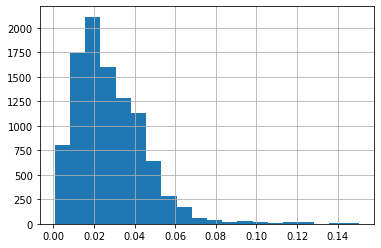

In [7]:
# how does it behave?
dataset['distance'].hist(bins=20)

## Separating Datasets
Let's put aside the submission data with empty times as we will predict them later, this is
20% of our data according to the dataset profile. The remaining set will be split into 70% and
30% for train and validation purposes.

In [8]:
# make a separate copy for the submission set
submission_dataset = dataset[np.isnan(dataset['total_minutes'])].copy()

# save and profile it
def profile(df, name, minimal=True):
    prof = ProfileReport(df, minimal=minimal)
    prof.to_file(name)
profile(submission_dataset, './profiles/submission.html')

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
# make a separate copy for the model
model_dataset = dataset[np.isnan(dataset['total_minutes']) == 0].copy()

# separate our label total_minutes from the set
total_minutes = model_dataset['total_minutes'].copy()
model_dataset.drop('total_minutes', axis=1, inplace=True)

# impute some values remaining in pop_wei, sum_wei, pop_uni, sum_uni
model_dataset = model_dataset.fillna(model_dataset.mean())

model_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            8000 non-null   float64
 1   lng            8000 non-null   float64
 2   on_demand      8000 non-null   bool   
 3   day            8000 non-null   int64  
 4   hour           8000 non-null   int64  
 5   sum_uni        8000 non-null   float64
 6   sum_wei        8000 non-null   float64
 7   pop_uni        8000 non-null   float64
 8   pop_wei        8000 non-null   float64
 9   seniority      8000 non-null   int64  
 10  found_rate     8000 non-null   float64
 11  picking_speed  8000 non-null   float64
 12  accepted_rate  8000 non-null   float64
 13  rating         8000 non-null   float64
 14  lat_store      8000 non-null   float64
 15  lng_store      8000 non-null   float64
 16  branch_size    8000 non-null   int64  
 17  city           8000 non-null   int64  
 18  distance

## Modelling stage
We complete the preamble to train a LightGBM model with the dataset. LightGBM model
parameters are tuneable:

* boosting_type:
    * ‘gbdt’, traditional Gradient Boosting Decision Tree.
    * ‘dart’, Dropouts meet Multiple Additive Regression Trees.
    * ‘goss’, Gradient-based One-Side Sampling.
    * ‘rf’, Random Forest
* num_leaves: Maximum tree leaves for base learners.
* max_depth: Maximum tree depth for base learners, <=0 means no limit.
* learning_rate: Boosting learning rate. This will ignore the learning_rate argument in training.
* n_estimators: Number of boosted trees to fit.
* objective: Specify the learning task and the corresponding learning objective. Default ‘regression’ for LGBMRegressor.
* TODO: add more parameters!

In [22]:
#make train and test splits
random_state = 0
x_train, x_test, y_train, y_test = train_test_split(model_dataset, total_minutes,
                                                    test_size=0.3, random_state=random_state)
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

# specify your configurations as a dict
params = {  # defaults
    'boosting_type': 'gbdt',  # gbdt
    'objective': 'regression',  # binary
    'metric': ['l1', 'l2', 'l2_root'],  # l2
    'num_leaves': 50,  # TODO
    'learning_rate': 0.05,  # 0.1
    'verbose': 0,  # default 1
    #'min_data_in_leaf': 300,  # TODO
    'feature_fraction': 0.8,  # TODO
    'bagging_fraction': 0.8,  # TODO
    'bagging_freq': 10,  # TODO
    'reg_sqrt': True  # this helps us predict big numerical labels
}

## Training stage

In [23]:
model_lgb = lgb.train(params, lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=20,
                      verbose_eval=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [24]:
# check predictions accuracy
lgb_train_pred = model_lgb.predict(x_train, num_iteration=model_lgb.best_iteration)
lgb_test_pred = model_lgb.predict(x_test, num_iteration=model_lgb.best_iteration)

Average error in minutes = 16.3411298240648


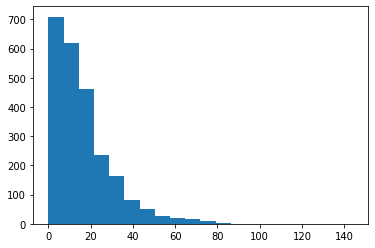

In [25]:
# plot the error on test dataset
plt.hist(abs(lgb_test_pred - y_test), bins=20)
print(f'Average error in minutes = {np.mean(abs(lgb_test_pred - y_test))}')

Average minutes of an order = 80.55005531193764


(array([ 16., 146., 325., 397., 443., 298., 247., 180., 133.,  88.,  57.,
         35.,  18.,  10.,   2.,   3.,   1.,   0.,   0.,   1.]),
 array([ 11.96948947,  25.16596267,  38.36243586,  51.55890906,
         64.75538226,  77.95185546,  91.14832866, 104.34480185,
        117.54127505, 130.73774825, 143.93422145, 157.13069465,
        170.32716785, 183.52364104, 196.72011424, 209.91658744,
        223.11306064, 236.30953384, 249.50600704, 262.70248023,
        275.89895343]),
 <BarContainer object of 20 artists>)

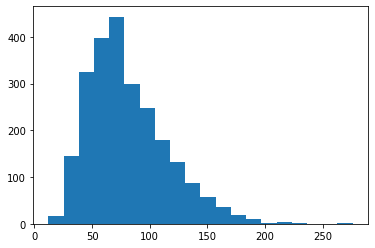

In [26]:
# plot the magnitude of values we're working with
print(f'Average minutes of an order = {np.mean(y_test)}')
plt.hist(y_test, bins=20)

In [27]:
# calculate RMSE for test set
rms = mean_squared_error(y_test, lgb_test_pred, squared=False)
print(f'RMSE Test = {rms}')

# same for train set
rms = mean_squared_error(y_train, lgb_train_pred, squared=False)
print(f'RMSE Train = {rms}')

RMSE Test = 21.892777593259865
RMSE Train = 14.507870348980369


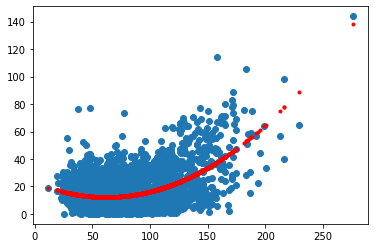

In [28]:
# we would at least like that the values with most error are those that take longer
absolute_error = abs(lgb_test_pred - y_test)
plt.scatter(y_test, absolute_error)

# also add the main behaviour of the scatter
fit = np.polyfit(y_test, absolute_error, 2)
p = np.poly1d(fit)
plt.plot(y_test, p(y_test), 'r.')
plt.show()

In [29]:
# moment of truth: is our model better than just having the average time?
average = y_test.mean()
averages = [average for _ in y_test]
rms = mean_squared_error(y_test, averages, squared=False)
print(f'RMSE of simplest model possible (average) = {rms}')

RMSE of simplest model possible (average) = 33.70139647446622


In average, we miss the mark by 16 minutes and an order takes around 80 minutes to process,
model is also much better than just returning the average of the set which is always a relief.

Honestly not so bad for a baseline model-and-go kind of method! Maybe this model is enough
to achieve a better performance, let's tune it!

## Tuning our baseline: Understand the model using SHAP

With the shap library we can compute what features are impacting our model:

In [19]:
# calculate shap values
explainer = shap.Explainer(model_lgb)
shap_values = explainer(x_test)

C extension was not built during install!
C extension was not built during install!


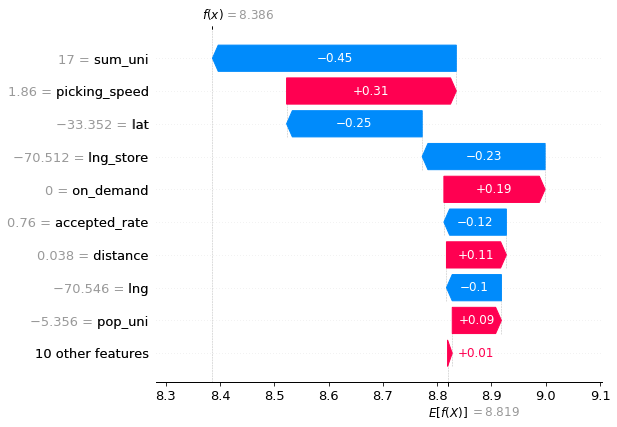

In [20]:
# visualize a sample and prediction explanation
shap.plots.waterfall(shap_values[0])

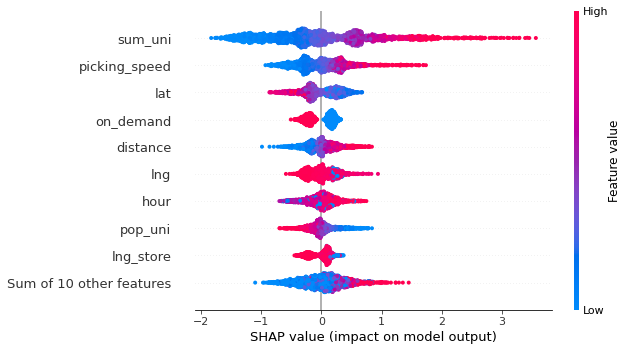

In [21]:
shap.plots.beeswarm(shap_values)

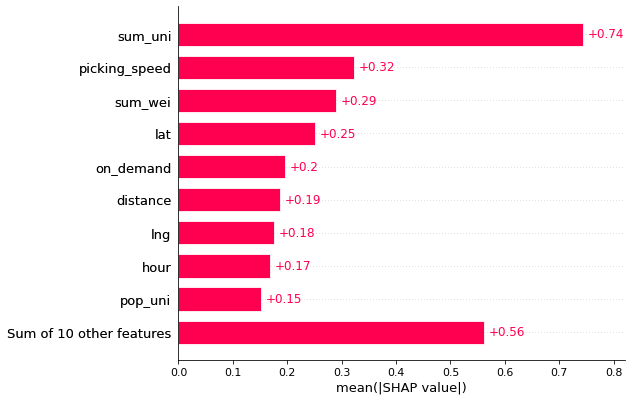

In [22]:
shap.plots.bar(shap_values)

### Managing features
From the shap plots we could suspect that lat, lng features could be redundant with distance feature,
also the unix time values could be of some use. It seems overall that the biggest the order,
the longest it takes.

EDIT: Actually they do give a bit of performance, so instead of
deleting lat lng values let's delete city (as 93% of data is from Santiago)
and day value (seems to be irrelevant for our model) but keeping hour from time.

In [33]:
# try eliminating lat, lng values and just leaving distance.
model_dataset_skinned = model_dataset.copy()
model_dataset_skinned.drop(['city', 'day'], axis=1, inplace=True)

#make train and test splits
random_state = 0
x_train, x_test, y_train, y_test = train_test_split(model_dataset_skinned, total_minutes,
                                                    test_size=0.3, random_state=random_state)
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [88]:
%%time
# create another model
model_lgb = lgb.train(params, lgb_train,
                      num_boost_round=500,
                      valid_sets=lgb_eval,
                      early_stopping_rounds=20,
                      verbose_eval=False)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000730 seconds.
You can set `force_col_wise=true` to remove the overhead.
Wall time: 396 ms


In [35]:
# check predictions accuracy
lgb_test_pred = model_lgb.predict(x_test, num_iteration=model_lgb.best_iteration)

# calculate RMSE for test set
rms = mean_squared_error(y_test, lgb_test_pred, squared=False)
print(f'RMSE Test = {rms}')

# same for train set
rms = mean_squared_error(y_train, lgb_train_pred, squared=False)
print(f'RMSE Train = {rms}')


RMSE Test = 22.086692624842158
RMSE Train = 14.507870348980369


In [30]:
# calculate shap values
explainer = shap.Explainer(model_lgb)
shap_values = explainer(x_test)

C extension was not built during install!
C extension was not built during install!


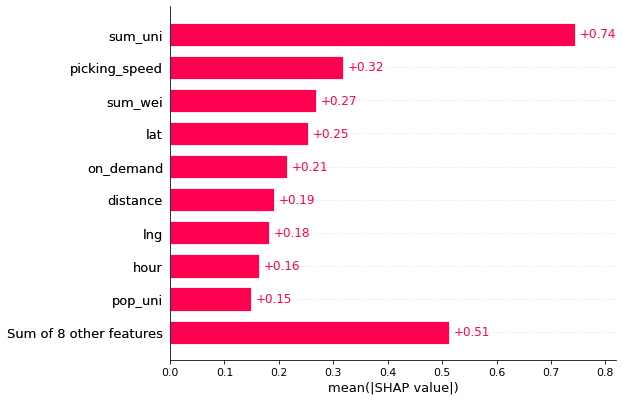

In [34]:
shap.plots.bar(shap_values)

Seems like we're definitely missing something with the singular geographical notations,
seems like some areas in Santiago work differently, so we'll keep that in the
dataset.

Seems like contribution from city and day is certainly minimal, so we'll take
them out.

For now this initial model is the best baseline,
now we'll make a more sophisticated model to compete
with it (Deep Neural Network based).

## Making a DNN model on Tensorflow
We'll implement a "simple" DNN model with two RELU layers, with a deeper network
we would induce vanishing gradient problems and to prevent over-fitting
we'll add dropout layer after reach RELU.

Also increasing epochs or number of neurons do not raise our performance,
the resulting model is crafted like this:

In [257]:
# check dataset
model_dataset_skinned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            8000 non-null   float32
 1   lng            8000 non-null   float32
 2   on_demand      8000 non-null   float32
 3   hour           8000 non-null   float32
 4   sum_uni        8000 non-null   float32
 5   sum_wei        8000 non-null   float32
 6   pop_uni        8000 non-null   float32
 7   pop_wei        8000 non-null   float32
 8   seniority      8000 non-null   float32
 9   found_rate     8000 non-null   float32
 10  picking_speed  8000 non-null   float32
 11  accepted_rate  8000 non-null   float32
 12  rating         8000 non-null   float32
 13  lat_store      8000 non-null   float32
 14  lng_store      8000 non-null   float32
 15  branch_size    8000 non-null   float32
 16  distance       8000 non-null   float32
dtypes: float32(17)
memory usage: 593.8 KB


In [258]:
# tf requires floats to be of format np.float32
def to_float32(df):
    for col in df.columns:
        my_type = df[col].dtype
        if my_type == np.float64 or my_type == np.bool:
            df[col] = df[col].astype(np.float32)

# convert to float32
to_float32(model_dataset_skinned)
# same for output
total_minutes = total_minutes.astype(np.float32)

In [259]:
# start with a normalizer layer
normalizer = preprocessing.Normalization(axis=-1)
# adapt to our train set
normalizer.adapt(np.array(model_dataset_skinned))
print(normalizer.mean.numpy())  # just to check normalizer layer values

[[-3.3425842e+01 -7.0668053e+01  4.5474997e-01  1.5979884e+01
   3.4453606e+01  1.7250986e+00 -2.3809550e+00  2.3389702e+00
   5.6312519e-01  8.6331773e-01  1.6901116e+00  9.1651136e-01
   4.8506980e+00 -3.3430202e+01 -7.0662018e+01  2.7276623e+01
   2.8013604e-02]]


In [270]:
# compose the model layers
model = keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
  ])

model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(0.001))

In [271]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_9 (Normalizati (None, 17)                35        
_________________________________________________________________
dense_99 (Dense)             (None, 64)                1152      
_________________________________________________________________
dropout_28 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 65        
Total params: 5,412
Trainable params: 5,377
Non-trainable params: 35
__________________________________________________

In [272]:
%%time
history = model.fit(model_dataset_skinned,
                    total_minutes,
                    validation_split=0.4,
                    verbose=0,
                    epochs=200)

Wall time: 22.8 s


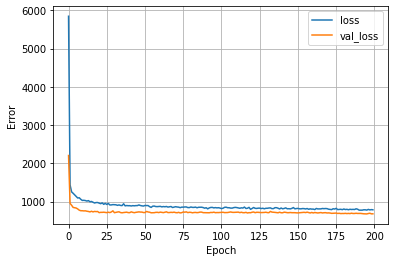

In [273]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

## Check DNN model vs our Baseline LightGBM

Our DNN model could be a bit more sophisticated, and it takes ten times longer
to train (500 ms vs 5 seconds) although both are still simple enough models.

From both results which one has a better RMSE (Root Mean Squared Error)?

In [274]:
to_float32(x_test)
x_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2400 entries, 3853 to 2668
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lat            2400 non-null   float32
 1   lng            2400 non-null   float32
 2   on_demand      2400 non-null   float32
 3   hour           2400 non-null   int64  
 4   sum_uni        2400 non-null   float32
 5   sum_wei        2400 non-null   float32
 6   pop_uni        2400 non-null   float32
 7   pop_wei        2400 non-null   float32
 8   seniority      2400 non-null   int64  
 9   found_rate     2400 non-null   float32
 10  picking_speed  2400 non-null   float32
 11  accepted_rate  2400 non-null   float32
 12  rating         2400 non-null   float32
 13  lat_store      2400 non-null   float32
 14  lng_store      2400 non-null   float32
 15  branch_size    2400 non-null   int64  
 16  distance       2400 non-null   float32
dtypes: float32(14), int64(3)
memory usage: 206.2 KB


RMSE LGBM = 22.086692624842158
RMSE DNN = 25.138962885736312
Average error in minutes = 16.488114643057568


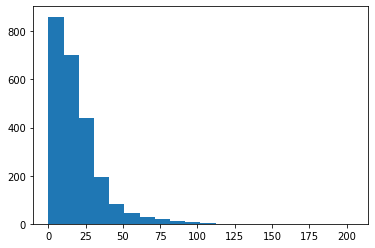

In [276]:
# Let' calculate the RMSE and MAE for LGBM and DNN models
# DNN model:
results_dnn = model.predict(x_test, verbose=0).flatten()
results_lgb = np.array(model_lgb.predict(x_test, num_iteration=model_lgb.best_iteration))

# calculate RMSE for test set
rms = mean_squared_error(y_test, results_lgb, squared=False)
print(f'RMSE LGBM = {rms}')

rms = mean_squared_error(y_test, results_dnn, squared=False)
print(f'RMSE DNN = {rms}')

# plot the error on test dataset on DNN
plt.hist(abs(results_dnn - y_test), bins=20)
print(f'Average error in minutes = {np.mean(abs(lgb_test_pred - y_test))}')

## Conclusions

Our DNN models needs more time to reduce over-fitting other than dropouts,
then maybe it will perform slightly better than LGBM model, for now we'll submit
our baseline results!

In [277]:
# calculate total_minutes
submission_label = submission_dataset['total_minutes'].copy()
# we'll use skinned version of model
submission_dataset.drop(['total_minutes', 'city', 'day'], axis=1, inplace=True)
total_minutes = model_lgb.predict(submission_dataset)
# add our values predicted back
submission_dataset['total_minutes'] = total_minutes
submission_dataset

,lat,lng,on_demand,hour,sum_uni,sum_wei,pop_uni,pop_wei,seniority,found_rate,picking_speed,accepted_rate,rating,lat_store,lng_store,branch_size,distance,total_minutes
2,-32.987022,-71.544842,True,14,18.0,0.000,-5.956135,0.000000,1,0.8313,2.57,0.76,4.92,-33.008213,-71.545615,33,0.021205,72.796860
5,-33.330724,-70.547074,True,23,15.0,0.000,-11.648569,0.000000,0,0.8946,1.82,1.00,4.84,-33.357558,-70.515415,17,0.041502,72.440780
9,-33.349922,-70.522841,True,21,94.0,2.852,11.780279,2.462134,0,0.9363,1.67,1.00,4.84,-33.370765,-70.512420,33,0.023303,83.300359
12,-33.430068,-70.571788,False,16,41.0,5.071,-10.492461,7.372009,0,0.8856,1.27,0.92,4.80,-33.441246,-70.535450,33,0.038018,97.244579
18,-33.427389,-70.605832,True,15,3.0,0.000,-3.281501,0.000000,1,0.8560,1.79,0.84,4.84,-33.430257,-70.603000,23,0.004030,47.425028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,-33.415810,-70.602627,False,19,41.0,1.990,3.458618,5.878834,2,0.8492,2.08,0.92,5.00,-33.386547,-70.568075,33,0.045279,111.478077
9976,-33.235834,-70.692367,True,15,33.0,0.745,-3.119927,2.409785,1,0.9070,1.84,0.84,5.00,-33.276854,-70.628167,33,0.076185,84.787186
9978,-33.439055,-70.546244,False,0,6.0,0.000,-6.045445,0.000000,1,0.8645,3.14,1.00,4.56,-33.440737,-70.543532,19,0.003191,53.886630
9988,-33.504379,-70.663026,False,19,16.0,0.000,-6.741144,0.000000,0,0.8594,1.38,0.96,4.80,-33.512578,-70.655952,33,0.010829,93.891363


In [278]:
# save submission
submission_dataset.to_csv('./data/submission.csv')